RNN multiple features
weather history data

In [39]:
###-----------------
### Import Libraries
###-----------------
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error

import tensorflow as tf
# from utils.helper import fn_plot_tf_hist

In [40]:
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]

    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()

In [41]:
### ----------------------
### global variables
### ----------------------

import random

RANDOM_STATE = 24

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


TEST_SIZE = 0.2
ALPHA = 0.001 # LEARNING RATE
EPOCHS = 30  # NUMBER OF ITERATIONS
BATCH_SIZE = 64                 # Default for Tensorflow

# input and output directories
inpDir = '../../input'
outDir = '../output'

params = {
    'legend.fontsize': 'medium',
    'figure.figsize': (10, 6),
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium'
}

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

# Load Shakespeare Data

In [42]:
fileName = 'shakespeare.txt'
filepath = os.path.join(os.getcwd(), fileName)
filepath

'/content/shakespeare.txt'

In [43]:
text = open(filepath, 'rb').read().decode(encoding = 'utf-8')
len(text)

1115395

In [44]:
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [45]:
# Char based modeling

In [46]:
vocab = sorted(set(text))
len(vocab)

65

In [47]:
char2idx = {u : i for i, u in enumerate(vocab)}
idx2char = np.array(vocab) # in array i can refer element by idx

In [48]:
text_as_int = np.array([char2idx[c] for c in text])
text_as_int

array([18, 47, 56, ...,  8,  0,  0])

In [49]:
type(text_as_int)

numpy.ndarray

In [50]:
seq_length = 100
example_per_epoch = len(text) // (seq_length + 1)
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(20):
    print(i.numpy(), end = " : " )
    print(idx2char[i.numpy()])
    print

18 : F
47 : i
56 : r
57 : s
58 : t
1 :  
15 : C
47 : i
58 : t
47 : i
64 : z
43 : e
52 : n
10 : :
0 : 

14 : B
43 : e
44 : f
53 : o
56 : r


In [51]:
sequences = char_dataset.batch(seq_length + 1, drop_remainder= True)

for item in sequences.take(1):
    print(item)
    print(repr("".join(idx2char[item.numpy()])))

tf.Tensor(
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1], shape=(101,), dtype=int64)
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [52]:
def split_input_target(chunk):
    input_text = chunk[:-1]     # first hundred characters
    target_text = chunk[1:]     # offset one as target
    return input_text, target_text

dataset = sequences.map(split_input_target)


In [53]:
for inp_ex, tar_ex in dataset.take(1):
    print(repr("".join(idx2char[inp_ex.numpy()])))
    print(repr("".join(idx2char[tar_ex.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [54]:
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE,
                                            drop_remainder = True)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [55]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

In [56]:
def build_model(vocab_size,
                embedding_dim,
                rnn_units,
                batch_size = BATCH_SIZE):

    return tf.keras.Sequential([
        tf.keras.layers.Input(shape = (None, ),
                              batch_size = BATCH_SIZE),
        tf.keras.layers.Embedding(vocab_size,
                                  embedding_dim),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences = True,
                            stateful = True,
                            recurrent_initializer = "glorot_uniform"),
        tf.keras.layers.Dense(vocab_size)
    ])



In [63]:
model = build_model(vocab_size, embedding_dim, rnn_units)


In [64]:
for inp_ex, tar_ex in dataset.take(1):
    ex_pred = model(inp_ex)

In [65]:
len(ex_pred)

64

In [66]:
# why we sample

sample_indices = tf.random.categorical(ex_pred[0], num_samples = 1)
print(sample_indices.shape)

(100, 1)


In [67]:
sample_indices = tf.squeeze(sample_indices, axis = -1).numpy()
sample_indices.shape

(100,)

In [ ]:
x_train = x_data[: split]
x_test = x_data[split : ]
y_train = y_df['temp'].values[: split]
y_test = y_df['temp'].values[split:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3214, 23, 4), (804, 23, 4), (3214,), (804,))

In [ ]:
h_units = 256
input_shape = (time_step - 1, x_train.shape[2])
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = input_shape))
model.add(tf.keras.layers.SimpleRNN(units = h_units,
                                    kernel_initializer = initializer,
                                    activation = 'tanh'))
model.add(tf.keras.layers.Dense(1,
                                kernel_initializer = initializer,
                                activation = 'linear'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, 256)                 │          66,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,073 (262.00 KB)

 Trainable params: 67,073 (262.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer = "adam",
              loss = 'mean_squared_error',
              metrics = [tf.keras.metrics.RootMeanSquaredError(name = 'RMSE')])

history = model.fit(x_train, y_train,
                    validation_data = [x_test, y_test],
                    batch_size = BATCH_SIZE,
                    verbose = 2,
                    epochs = EPOCHS)

Epoch 1/30
101/101 - 4s - 38ms/step - RMSE: 8.3823 - loss: 70.2623 - val_RMSE: 7.2662 - val_loss: 52.7970
Epoch 2/30
101/101 - 2s - 21ms/step - RMSE: 8.1825 - loss: 66.9534 - val_RMSE: 7.3541 - val_loss: 54.0832
Epoch 3/30
101/101 - 4s - 37ms/step - RMSE: 8.2495 - loss: 68.0547 - val_RMSE: 7.2327 - val_loss: 52.3117
Epoch 4/30
101/101 - 3s - 33ms/step - RMSE: 8.1373 - loss: 66.2162 - val_RMSE: 7.5531 - val_loss: 57.0488
Epoch 5/30
101/101 - 2s - 21ms/step - RMSE: 8.2073 - loss: 67.3599 - val_RMSE: 7.3395 - val_loss: 53.8684
Epoch 6/30
101/101 - 3s - 25ms/step - RMSE: 8.0928 - loss: 65.4934 - val_RMSE: 7.3805 - val_loss: 54.4721
Epoch 7/30
101/101 - 2s - 24ms/step - RMSE: 8.0508 - loss: 64.8153 - val_RMSE: 7.4290 - val_loss: 55.1904
Epoch 8/30
101/101 - 3s - 34ms/step - RMSE: 7.9930 - loss: 63.8885 - val_RMSE: 7.4826 - val_loss: 55.9901
Epoch 9/30
101/101 - 2s - 19ms/step - RMSE: 7.9084 - loss: 62.5433 - val_RMSE: 7.4247 - val_loss: 55.1267
Epoch 10/30
101/101 - 2s - 20ms/step - RMSE: 7

In [ ]:
hist_df = pd.DataFrame(history.history)
display(hist_df.head())

,RMSE,loss,val_RMSE,val_loss
0,8.382258,70.262260,7.266154,52.796993
1,8.182504,66.953369,7.354127,54.083187
2,8.249530,68.054749,7.232682,52.311695
3,8.137335,66.216217,7.553066,57.048809
4,8.207310,67.359932,7.339510,53.868416


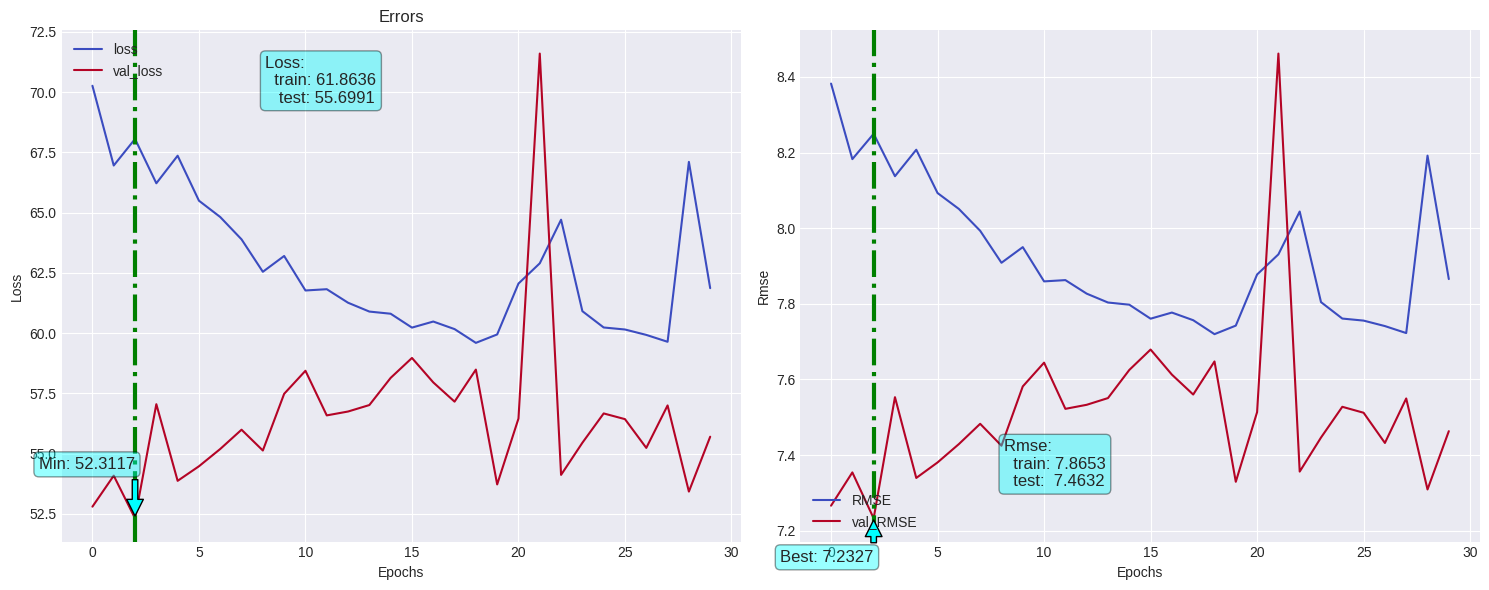

In [ ]:
fn_plot_tf_hist(hist_df = hist_df)

In [ ]:
y_tr_pred = model.predict(x_train)
y_ts_pred = model.predict(x_test)
y_pred = np.append(y_tr_pred, y_ts_pred)

res_df = y_df.copy()
res_df['pred'] = y_pred
res_df.head()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,datetime,temp,pred
24,2006-01-01 23:00:00+00:00,5.422222,10.059216
48,2006-01-02 23:00:00+00:00,1.694444,8.816135
72,2006-01-03 23:00:00+00:00,2.200000,8.450389
96,2006-01-04 23:00:00+00:00,1.666667,4.405884
120,2006-01-05 23:00:00+00:00,1.805556,6.565093


<Axes: xlabel='datetime'>

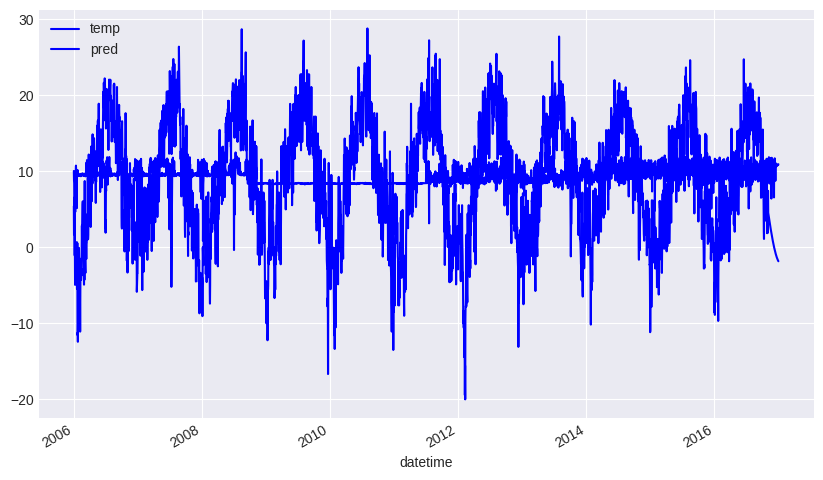

In [ ]:
res_df.plot(x = 'datetime', y = ['temp', 'pred'], color = 'blue')